In [1]:
import os
from tqdm import tqdm
import datetime
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import hashlib

# set seed
seed = 42
np.random.seed(seed)
random.seed(seed)

In [2]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## Question 4

Q4. Consider the following dataset and query set:
   - Generate a corpus of 1 million random strings, each of length 100
   - Create a query set of size 5,000 where:
     - 50% (2,500) are randomly selected from the corpus
     - 50% (2,500) are new random strings not in the corpus

Implement a Bloom filter ($m$ bits, $k$ hash functions) for answering whether each of the queries are present in the data. For the $k$ hash functions, use MD5 with $k$ different seeds and then do a $\mod(\cdot)$ to get a number in $[0,m)$.

Fix the size of the Bloom filter to $m=1024$ bits. Do different implementations, one for each $k\in\{2,4,6,8,10,12\}$. Plot $k$ (number of hash functions) vs false positive rate. Determine the optimal $k$ for your dataset. Find out the optimal $k$ for your dataset and calculate the empirical false positive rate for that too.

In [3]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m  # size of the bloom filter in bits
        self.k = k  # number of hash functions
        self.bit_array = np.zeros(m, dtype=bool)  # bit array to store the bloom filter
    
    def _hash(self, item, seed):
        # use md5 hash function with different seeds
        hash_object = hashlib.md5((item + str(seed)).encode())
        hash_value = int(hash_object.hexdigest(), 16) % self.m
        return hash_value
    
    def insert(self, item):
        # insert an item into the bloom filter
        for i in range(self.k):
            hash_value = self._hash(item, i)
            self.bit_array[hash_value] = True
    
    def query(self, item):
        # query an item in the bloom filter
        for i in range(self.k):
            hash_value = self._hash(item, i)
            if not self.bit_array[hash_value]:
                return False
        return True

def theoretical_fp_rate(m, n, k):
    # calculate the theoretical false positive rate
    return (1 - np.exp(-k*n/m))**k

def theoretical_optimal_k(m, n):
    # calculate the theoretical optimal k
    return int((m/n) * np.log(2))

def m_for_fp_rate(fp_rate, n):
    # calculate the size of the bloom filter for a given false positive rate
    return int(np.ceil(-n * np.log(fp_rate) / (np.log(2)**2)))


In [4]:
corpus_size = 1000000
query_size = 5000
string_length = 100
required_fp_rate = 0.05
m = m_for_fp_rate(required_fp_rate, corpus_size)
print("Value of m for required false positive rate:", m)        # size of bloom filter
# m=1024
k_values = [2, 4, 6, 8, 10, 12]          # number of hash functions

run_dir = save_dirs[3] + "runs/"
if not os.path.exists(run_dir):
    os.makedirs(run_dir)
run_file = run_dir + "bloom_run_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".txt"
print("Run file:", run_file)

Value of m for required false positive rate: 6235225
Run file: ./assets/assignment2/Q4/runs/bloom_run_20250404_095308.txt


In [ ]:
create_corpus = True
run_bloom = True

In [6]:
def generate_random_string(length=100):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for i in range(length))

if create_corpus:
    # create a corpus of 1 million random strings, each of length 100
    print("Generating corpus...")
    corpus = [generate_random_string(string_length) for _ in tqdm(range(corpus_size))]
    corpus_set = set(corpus)
    with open(save_dirs[3] + "corpus.txt", "w") as f:
        f.write("\n".join(corpus))
    
    # create a query set of size 5,000 where:
    # 50% (2,500) are randomly selected from the corpus
    # 50% (2,500) are new random strings not in the corpus
    print("Generating query set...")
    positive_queries = random.sample(corpus, query_size//2)
    negative_queries = []
    while len(negative_queries) < query_size//2:
        new_query = generate_random_string(string_length)
        if new_query not in corpus_set:
            negative_queries.append(new_query)
    query_set = positive_queries + negative_queries
    random.shuffle(query_set)
    with open(save_dirs[3] + "queries.txt", "w") as f:
        f.write("\n".join(query_set))
    with open(save_dirs[3] + "positive_queries.txt", "w") as f:
        f.write("\n".join(positive_queries))
    with open(save_dirs[3] + "negative_queries.txt", "w") as f:
        f.write("\n".join(negative_queries))

else:
    print("Loading corpus...")
    with open(save_dirs[3] + "corpus.txt", "r") as f:
        corpus = f.read().splitlines()
    corpus_set = set(corpus)
    print("Loading query set...")
    with open(save_dirs[3] + "queries.txt", "r") as f:
        query_set = f.read().splitlines()
    with open(save_dirs[3] + "positive_queries.txt", "r") as f:
        positive_queries = f.read().splitlines()
    with open(save_dirs[3] + "negative_queries.txt", "r") as f:
        negative_queries = f.read().splitlines()
    print("Corpus and query set loaded successfully.")

Loading corpus...


Loading query set...
Corpus and query set loaded successfully.


In [7]:
if run_bloom:
    with open(run_file, "w") as f:
        f.write(f"Corpus size: {corpus_size}\n")
        f.write(f"Query size: {query_size}\n")
        f.write(f"String length: {string_length}\n")
        f.write(f"Bloom filter size (m): {m}\n")
        f.write(f"Hash functions (k): {k_values}\n")
        
    fp_rate_results = []
    for k in k_values:
        print(f"Running Bloom filter with k={k}...")
        # create a bloom filter with m bits and k hash functions
        bloom_filter = BloomFilter(m, k)
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0
    
        # insert all items in the corpus into the bloom filter
        for item in tqdm(corpus):
            bloom_filter.insert(item)
        
        # query the bloom filter with the query set
        print("Querying Bloom filter...")
        for item in tqdm(query_set):
            if item in positive_queries:
                if bloom_filter.query(item):
                    true_positives += 1
                else:
                    false_negatives += 1
            else:
                if bloom_filter.query(item):
                    false_positives += 1
                else:
                    true_negatives += 1

        # confusion matrix
        print(f"Confusion Matrix for k={k}:")
        print(f"    True Positives: {true_positives}, False Positives: {false_positives}")
        print(f"    True Negatives: {true_negatives}, False Negatives: {false_negatives}")
        # calculate false positive rate
        false_positive_rate = false_positives / (query_size//2)
        print(f"False Positive Rate for k={k}: {false_positive_rate:.4f}\n")
        fp_rate_results.append((k, false_positive_rate))
        
        # save the results
        with open(run_file, "a") as f:
            f.write(f"\nRunning Bloom filter with k={k}...\n")
            f.write(f"Confusion Matrix for k={k}:\n")
            f.write(f"True Positives: {true_positives}, False Positives: {false_positives}\n")
            f.write(f"True Negatives: {true_negatives}, False Negatives: {false_negatives}\n")
            f.write(f"False Positive Rate for k={k}: {false_positive_rate:.4f}\n")
    np.save(save_dirs[3] + "fp_rate_results.npy", fp_rate_results)

else:
    print("Loading Bloom filter results...")
    fp_rate_results = np.load(save_dirs[3] + "fp_rate_results.npy", allow_pickle=True).tolist()

Running Bloom filter with k=2...


100%|██████████| 1000000/1000000 [00:12<00:00, 79888.68it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 17851.11it/s]


Confusion Matrix for k=2:
    True Positives: 2500, False Positives: 223
    True Negatives: 2277, False Negatives: 0
False Positive Rate for k=2: 0.0892

Running Bloom filter with k=4...


100%|██████████| 1000000/1000000 [00:21<00:00, 45675.89it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 7519.99it/s]


Confusion Matrix for k=4:
    True Positives: 2500, False Positives: 126
    True Negatives: 2374, False Negatives: 0
False Positive Rate for k=4: 0.0504

Running Bloom filter with k=6...


100%|██████████| 1000000/1000000 [00:40<00:00, 24707.99it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 18502.54it/s]


Confusion Matrix for k=6:
    True Positives: 2500, False Positives: 138
    True Negatives: 2362, False Negatives: 0
False Positive Rate for k=6: 0.0552

Running Bloom filter with k=8...


100%|██████████| 1000000/1000000 [00:30<00:00, 33117.11it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 15468.26it/s]


Confusion Matrix for k=8:
    True Positives: 2500, False Positives: 196
    True Negatives: 2304, False Negatives: 0
False Positive Rate for k=8: 0.0784

Running Bloom filter with k=10...


100%|██████████| 1000000/1000000 [01:08<00:00, 14561.64it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:01<00:00, 3654.80it/s]


Confusion Matrix for k=10:
    True Positives: 2500, False Positives: 286
    True Negatives: 2214, False Negatives: 0
False Positive Rate for k=10: 0.1144

Running Bloom filter with k=12...


100%|██████████| 1000000/1000000 [00:59<00:00, 16743.43it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 12800.42it/s]

Confusion Matrix for k=12:
    True Positives: 2500, False Positives: 363
    True Negatives: 2137, False Negatives: 0
False Positive Rate for k=12: 0.1452



Optimal k for the dataset: 4
Optimal False Positive Rate for the dataset: 0.0504
Theoretical optimal k: 4
False positive rate for theoretical optimal k: 0.0503


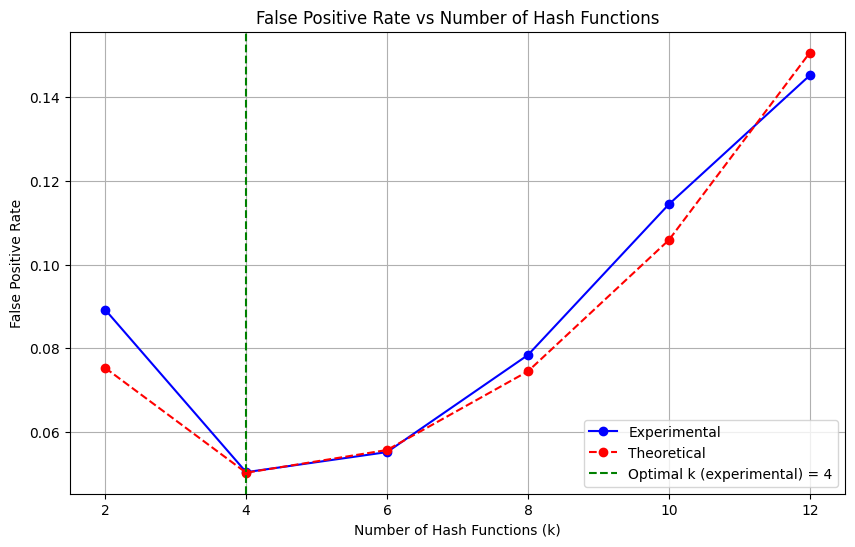

In [8]:
k_values, fp_rates = zip(*fp_rate_results)

optimal_k = k_values[np.argmin(fp_rates)]
optimal_fp_rate = min(fp_rates)
print(f"Optimal k for the dataset: {optimal_k}")
print(f"Optimal False Positive Rate for the dataset: {optimal_fp_rate:.4f}")

theo_opt_k = theoretical_optimal_k(m, corpus_size)
theo_rates = [theoretical_fp_rate(m, corpus_size, k) for k in k_values]
theo_fp_rate = theoretical_fp_rate(m, corpus_size, theo_opt_k)
print(f"Theoretical optimal k: {theo_opt_k}")
print(f"False positive rate for theoretical optimal k: {theo_fp_rate:.4f}")

# save the optimal k and false positive rate
if run_bloom:
    with open(run_file, "a") as f:
        f.write(f"\nOptimal k for the dataset: {optimal_k}\n")
        f.write(f"Optimal False Positive Rate for the dataset: {optimal_fp_rate:.4f}\n")
        f.write(f"\nTheoretical optimal k: {theo_opt_k}\n")
        f.write(f"False positive rate for theoretical optimal k: {theo_fp_rate:.4f}\n")


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, fp_rates, 'bo-', label='Experimental')
plt.plot(k_values, theo_rates, 'ro--', label='Theoretical')

# Mark optimal k
# plt.axvline(x=opt_k, color='g', linestyle='--', label=f'Optimal k (theoretical) = {opt_k}')
# Find experimental optimal k
exp_opt_k = k_values[fp_rates.index(min(fp_rates))]
plt.axvline(x=exp_opt_k, color='g', linestyle='--', label=f'Optimal k (experimental) = {exp_opt_k}')

plt.title('False Positive Rate vs Number of Hash Functions')
plt.xlabel('Number of Hash Functions (k)')
plt.ylabel('False Positive Rate')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.savefig(save_dirs[3] + "bloom_filter_fp_rate.png", dpi=300)
plt.show()
